# Coursera Capstone Project -- Data Science

## Notebook Imports

In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
#Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import folium
from fbprophet import Prophet

## Constants

In [3]:
AUSTIN_LAT = 30.2711286
AUSTIN_LONG = -97.7436995

# Section 1: Introduction to problem
Imagine planning to visit a city for a music festival or a work conference. While you are there you also plan to explore the city where it is occurring. You want to visit the top places to eat or other attractions while you are there but want to minimize the chances of getting robbed or stepping into a high crime area while you are there. So, for my capstone project I want to show with FourSquare location data being backed up by open crime data, there is a way to predict the likelihood of crime around the area a traveler plans to visit. Then use that result to plan a day where they have the lowest possible chance of being a victim of crime. This will mainly be targeted at frequent travelers that don’t have time to do extensive research on where they are going and need a quick collection of information to help plan their trip. 

In [4]:
# MAKE VISUALLY PLEASING LATER

# Section 2: Methodology of this application
## 2.1 Importing Data
In order to keep this project at a small scale and demonstrate the concept, we will assume the role of a travler going to Austin, TX for the SXSW festival. First we will import crime data obtained from: https://data.austintexas.gov/. This data ranges all the way from 2003 to 2020. The reason for such a large data set is allow for a more accurate and precise prediction for the crime rate. In order to save time the data was downloaded to my local machine in a csv file.

In [5]:
# Importing the crime data
austinCrime = pd.read_csv('AustinCrime/Crime_Reports.csv', low_memory = False)
austinCrime.head()

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,...,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,20125003262,PROTECTIVE ORDER,3829,N,01/23/2012 05:17:00 AM,01/23/2012,517.0,01/23/2012 05:17:00 AM,01/23/2012,517.0,...,NaN,N,01/23/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20072832112,ASSAULT WITH INJURY,900,N,10/10/2007 09:00:00 PM,10/10/2007,2100.0,10/10/2007 10:00:00 PM,10/10/2007,2200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20081232700,FAMILY DISTURBANCE,3400,N,05/02/2008 11:11:00 PM,05/02/2008,2311.0,05/02/2008 11:11:00 PM,05/02/2008,2311.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006900236,ASSAULT WITH INJURY,900,N,03/31/2006 02:50:00 AM,03/31/2006,250.0,03/31/2006 02:50:00 AM,03/31/2006,250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20081002040,CRASH/FAIL STOP AND RENDER AID,3604,N,04/09/2008 07:04:00 PM,04/09/2008,1904.0,04/09/2008 09:08:00 PM,04/09/2008,2108.0,...,NaN,N,12/16/2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next a little clean up of this data, to allow easier processing later.

In [6]:
# Rename some columns for clarity and to allow ease of access
austinCrime.rename(columns = {'Occurred Date Time': 'Date', 'Zip Code': 'Zipcode'}, inplace = True)

In [7]:
#Adjust the date time format to for ease of processing later on.
austinCrime.Date = pd.to_datetime(austinCrime.Date, format='%m/%d/%Y %I:%M:%S %p')
austinCrime.index = pd.DatetimeIndex(austinCrime.Date)

Next we will be importing data collected from foursquare about the venues around Austin,TX. The next few cells will go over how the data was collected. Due to the limitations on calls that can be made to the foursquare API, the data was collected over time and saved to a csv file in order to demonstrate how the data can be levreged. Note that in a commercail application these limitations would not be a problem as foursquare commercial accounts do not have a cap on the calls that can be made to it.

First we will load the basics for FourSquare to connect to foursquare.

In [8]:
CLIENT_ID = 'YOUR FOURSQUARE ID' # your Foursquare ID
CLIENT_SECRET = 'YOUR FOURSQUARE SECRET' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Now that the foursquare can be interacted in order to start making calls to it we need latitudes and longitudes. I will be using all of the zipcodes in the Austin Area and recording there latitude and longitudes found by https://public.opendatasoft.com/. This website has an API which will make gathering information from it much easier. 

In [9]:
# Fisrt set up the url for the call
zipcodes_url = 'https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&q=austin&rows=83&facet=state&facet=timezone&facet=dst&refine.state=TX'

### Breaking down the URL
https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&q=austin&rows=83&facet=state&facet=timezone&facet=dst&refine.state=TX

This url has 3 options that need to entered in order to get the information needed
q- this is just what we are seraching for we need Austin, TX so we just put in 'austin' for this term

rows- When previewing visual I saw that there are only 83 zipcodes in austin so we will set this to 83

refine.state- this will limit the results from query to only return for texas

In [10]:
# This function will gather all of the information needed and return a dataframe with that information.
def getAllLatandLong(url):
    
    #First initalize an empty dataframe
    info = pd.DataFrame(columns=['ZipCode', 'Longitude', 'Latitude'])
    
    #Make the call to the API and retrive the records
    records = requests.get(url).json()["records"]
    
    #Cycle through all records and record the inforamtion into the dataframe 
    for entry in records:
        zipcode = entry['fields']['zip']
        lat = entry['fields']['latitude']
        long = entry['fields']['longitude']
        dataEntry = {'ZipCode': int(zipcode), 'Longitude': long , 'Latitude': lat}
        info = info.append(dataEntry, ignore_index="True")
    return info

In [11]:
zipCodes = getAllLatandLong(zipcodes_url)
#Quick pre-process
zipCodes.ZipCode = zipCodes.ZipCode.astype(int)
zipCodes

,ZipCode,Longitude,Latitude
0,78745,-97.795750,30.207559
1,78759,-97.757430,30.406169
2,78774,-97.771258,30.326374
3,78788,-97.771258,30.326374
4,78710,-97.715123,30.351953
...,...,...,...
78,78763,-97.559807,30.335398
79,78715,-97.486509,30.450088
80,78749,-97.858280,30.216108
81,78785,-97.771258,30.326374


Now that all of the information as been gathered on the zipcodes we can start making calls to foursquare with the following function. This function will take all of the zipcodes along with their latitude and longitude, then search for venues within a given radius in meters(defualt 650).

In [12]:
def getVenues(names, latitudes, longitudes, radius=650):
    #Limit the amount of returned venues
    LIMIT = 500
    
    #Create an empty dataframe to record information to.
    data = pd.DataFrame(columns=['Zipcode', 'Zipcode Latitude', 'Zipcode Longitude',
                                'Venue', 'Venue Rating','Venue Latitude', 'Venue Longitude',
                                 'Venue Category'])
    
    #Now cycle through all of the provided inforamtion
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)

        #Take the results down to just the venues
        results = requests.get(url).json()["response"]['groups'][0]['items']

        for v in results:
            #Using the venue ID make another call to foursquare to get its rating.
            venue_id = v['venue']['id']

            rating_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
            res = requests.get(rating_url).json()
            
            #If the venue has no rating it will record no value
            try:
                rating = res['response']['venue']['rating']
            except:
                rating = None
            
            vname = v['venue']['name']
            vlat = v['venue']['location']['lat']
            vlng = v['venue']['location']['lng']
            cat = v['venue']['categories'][0]['name']
            
            entry = {'Zipcode': name, 'Zipcode Latitude': lat, 'Zipcode Longitude': lng,
                    'Venue': vname, 'Venue Rating': rating,'Venue Latitude': vlat, 
                     'Venue Longitude': vlng,'Venue Category': cat}
            data = data.append(entry, ignore_index=True)
            
    return data   

Next would be to call this function like this:

//Python Code

austin_venues = getVenues(names=zipCodes['ZipCode'],
                                   latitudes=zipCodes['Latitude'],
                                   longitudes=zipCodes['Longitude'])

//


Due to limitations of foursquare's API calls, all of the needed inforamtion is contained in a csv file after being collected in this manner over time by making the above funtion call over multiple days to get around the limitation. 

In [13]:
#Load the relevent inforamtion
austin_venues = pd.read_csv('austinVenuesRatings.csv')

In [14]:
austin_venues

,Zipcode,Zipcode Latitude,Zipcode Longitude,Venue,Venue Rating,Venue Latitude,Venue Longitude,Venue Category
0,78757,30.349455,-97.733280,Tacodeli,9.3,30.348610,-97.735124,Taco Place
1,78701,30.271270,-97.741030,Texas State Capitol,9.3,30.274368,-97.740692,Capitol Building
2,78702,30.265158,-97.718790,Lazarus Brewing Company,9.3,30.261770,-97.722267,Brewery
3,78712,30.285207,-97.735394,Harry Ransom Center (HRC),9.2,30.284245,-97.741092,Museum
4,78702,30.265158,-97.718790,Veracruz All Natural,9.2,30.263080,-97.713778,Taco Place
...,...,...,...,...,...,...,...,...
1061,78642,30.702882,-97.926900,Aire serv of roundrock,NaN,30.702784,-97.926729,Home Service
1062,78642,30.702882,-97.926900,Wittness Weapons,NaN,30.698601,-97.926155,Gun Shop
1063,78628,30.674349,-97.723380,The Overlook,NaN,30.674084,-97.723787,Lake
1064,78654,30.566681,-98.307560,AT&T,NaN,30.572280,-98.306992,Mobile Phone Shop


## Section 2.2: Pre-Processing the Data

First we will divide up the austinCrimes by zipcode in order to make the predictions for the crime rate. We will first start with removing rows that have no zipcode as they won't be useful.

In [15]:
austinCrime.dropna(subset = ["Zipcode"], inplace= True)
# Next adjust the zipcodes to work with our other dataframes
austinCrime.Zipcode = austinCrime.Zipcode.astype(int)
austinCrime

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Date,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,...,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
Date,,,,,,,,,,,,,,,,,,,,,
2018-09-11 19:55:00,20182541518,RAPE,200,N,2018-09-11 19:55:00,09/11/2018,1955.0,09/11/2018 11:52:00 PM,09/11/2018,2352.0,...,18.41,N,09/13/2018,11A,Rape,0.0,0.0,NaN,NaN,NaN
2007-10-29 16:25:00,20075059461,INDECENCY WITH A CHILD/CONTACT,1709,N,2007-10-29 16:25:00,10/29/2007,1625.0,10/29/2007 04:25:00 PM,10/29/2007,1625.0,...,24.36,N,10/30/2009,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2019-02-24 21:00:00,2019571113,ASSAULT CONTACT-SEXUAL NATURE,902,Y,2019-02-24 21:00:00,02/24/2019,2100.0,02/26/2019 04:00:00 PM,02/26/2019,1600.0,...,17.77,N,03/06/2019,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2016-05-20 12:00:00,20165025422,STATUTORY RAPE OF CHILD,208,N,2016-05-20 12:00:00,05/20/2016,1200.0,05/20/2016 12:00:00 PM,05/20/2016,1200.0,...,18.43,N,10/11/2016,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2008-02-18 09:41:00,2008490601,CAMPING IN PARK,3214,N,2008-02-18 09:41:00,02/18/2008,941.0,02/18/2008 09:41:00 AM,02/18/2008,941.0,...,NaN,C,02/20/2008,NaN,NaN,3116339.0,3116339.0,30.264565,-97.736481,"(30.26456469, -97.73648138)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-09-12 23:57:00,20052552011,DWI,2100,N,2005-09-12 23:57:00,09/12/2005,2357.0,09/12/2005 11:57:00 PM,09/12/2005,2357.0,...,2.00,C,11/18/2005,NaN,NaN,3114295.0,3114295.0,30.334253,-97.741086,"(30.33425261, -97.74108649)"
2018-03-26 23:50:00,2018851890,VIOL OF EMERG PROTECTIVE ORDER,3008,N,2018-03-26 23:50:00,03/26/2018,2350.0,03/26/2018 11:55:00 PM,03/26/2018,2355.0,...,15.00,C,03/27/2018,NaN,NaN,3125614.0,3125614.0,30.332481,-97.705246,"(30.3324806, -97.70524551)"
2016-07-01 21:39:00,20161831722,WARRANT ARREST NON TRAFFIC,3442,N,2016-07-01 21:39:00,07/01/2016,2139.0,07/01/2016 09:39:00 PM,07/01/2016,2139.0,...,11.00,NaN,NaN,NaN,NaN,3115761.0,3115761.0,30.266782,-97.738253,"(30.26678161, -97.73825313)"


Next drop columns that are irrelevent and making the dataframe harder to read.

In [16]:
dropColumns = ['X-coordinate', 'Y-coordinate', 'UCR Category', 
               'Clearance Date', 'PRA', 'Census Tract', 'Location', 'Clearance Status',
              'Category Description', 'Highest Offense Code', 'Report Date Time',
              'Council District', 'APD Sector', 'APD District', 'Occurred Date', 'Occurred Time',
              'Address', 'Family Violence', 'Report Date', 'Report Time', 'Incident Number', 
               'Location Type', 'Latitude', 'Longitude']
austinCrime = austinCrime.drop(dropColumns, 1)

In [17]:
austinCrime

,Highest Offense Description,Date,Zipcode
Date,,,
2018-09-11 19:55:00,RAPE,2018-09-11 19:55:00,78660
2007-10-29 16:25:00,INDECENCY WITH A CHILD/CONTACT,2007-10-29 16:25:00,78719
2019-02-24 21:00:00,ASSAULT CONTACT-SEXUAL NATURE,2019-02-24 21:00:00,78749
2016-05-20 12:00:00,STATUTORY RAPE OF CHILD,2016-05-20 12:00:00,78758
2008-02-18 09:41:00,CAMPING IN PARK,2008-02-18 09:41:00,78701
...,...,...,...
2005-09-12 23:57:00,DWI,2005-09-12 23:57:00,78756
2018-03-26 23:50:00,VIOL OF EMERG PROTECTIVE ORDER,2018-03-26 23:50:00,78752
2016-07-01 21:39:00,WARRANT ARREST NON TRAFFIC,2016-07-01 21:39:00,78701


Now with all of the pre-processing done to the austinCrime dataframe, next we will need to find the top venues in austin based on there score from foursquare

In [18]:
byRating = austin_venues.sort_values(by=['Venue Rating'], ascending=False)
topTenVenues = byRating.head(10)
topTenVenues

,Zipcode,Zipcode Latitude,Zipcode Longitude,Venue,Venue Rating,Venue Latitude,Venue Longitude,Venue Category
0,78757,30.349455,-97.733280,Tacodeli,9.3,30.348610,-97.735124,Taco Place
2,78702,30.265158,-97.718790,Lazarus Brewing Company,9.3,30.261770,-97.722267,Brewery
1,78701,30.271270,-97.741030,Texas State Capitol,9.3,30.274368,-97.740692,Capitol Building
3,78712,30.285207,-97.735394,Harry Ransom Center (HRC),9.2,30.284245,-97.741092,Museum
4,78702,30.265158,-97.718790,Veracruz All Natural,9.2,30.263080,-97.713778,Taco Place
5,78701,30.271270,-97.741030,The Roosevelt Room,9.2,30.267842,-97.746242,Cocktail Bar
6,78748,30.172020,-97.822650,Moontower Saloon,9.2,30.169304,-97.826456,Bar
7,78704,30.246309,-97.760870,El Primo Taco Truck,9.2,30.244737,-97.757562,Food Truck
13,78756,30.320206,-97.741770,Pinthouse Pizza,9.1,30.318748,-97.739086,Pizza Place
17,78757,30.349455,-97.733280,T22 Chicken Joint,9.1,30.347976,-97.735335,Fried Chicken Joint


## Section 2.3: Predicting crime rate by zipcode with Prophet

Prophet is a tool developed by Facebook's data science team to make predictions based on a time series. In this case what we will be predicting is the amount of crimes committed in a given zipcode based on the crime data we currently have for the Austin,TX.

In [19]:
# Get the zipcodes for all of the venues in austin
venue_zipcodes = austin_venues['Zipcode'].value_counts().index

In [20]:
venue_zipcodes

Int64Index([78712, 78756, 78705, 78701, 78702, 78634, 78664, 78704, 78748,
            78757, 78722, 78621, 78753, 78752, 78734, 78641, 78610, 78741,
            78751, 78726, 78727, 78653, 78728, 76574, 78735, 78681, 78713,
            78613, 78617, 78645, 78669, 78733, 78640, 78703, 78744, 78660,
            78729, 78731, 78723, 78749, 78654, 78642, 78736, 78739, 78724,
            78732, 78759, 78745, 78721, 78628, 78620, 78615, 78737, 78746,
            78652, 78742, 78750, 78626, 78758],
           dtype='int64')

Next I will walk through one prediction using prophet

In [21]:
regionCrime = austinCrime[austinCrime.Zipcode == 78748]
timeSeries = regionCrime.resample('M').size().reset_index()

In [22]:
timeSeries.tail()

,Date,0
204,2020-01-31,352
205,2020-02-29,273
206,2020-03-31,293
207,2020-04-30,260
208,2020-05-31,190


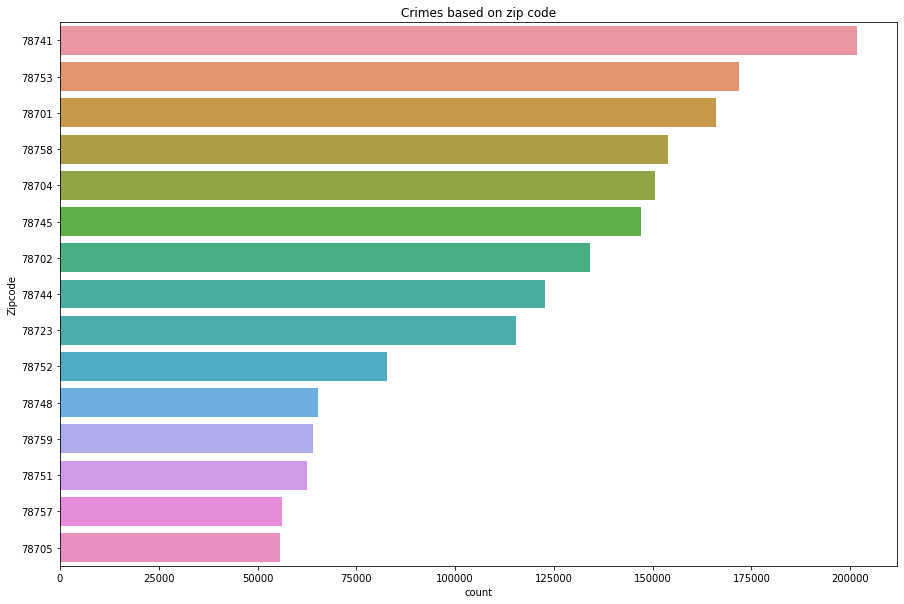

In [23]:
top15Areas = austinCrime['Zipcode'].value_counts().iloc[:15].index
plt.figure(figsize=(15,10))
plt.title('Crimes based on zip code')
sns.countplot(y='Zipcode', data=austinCrime, order= top15Areas)

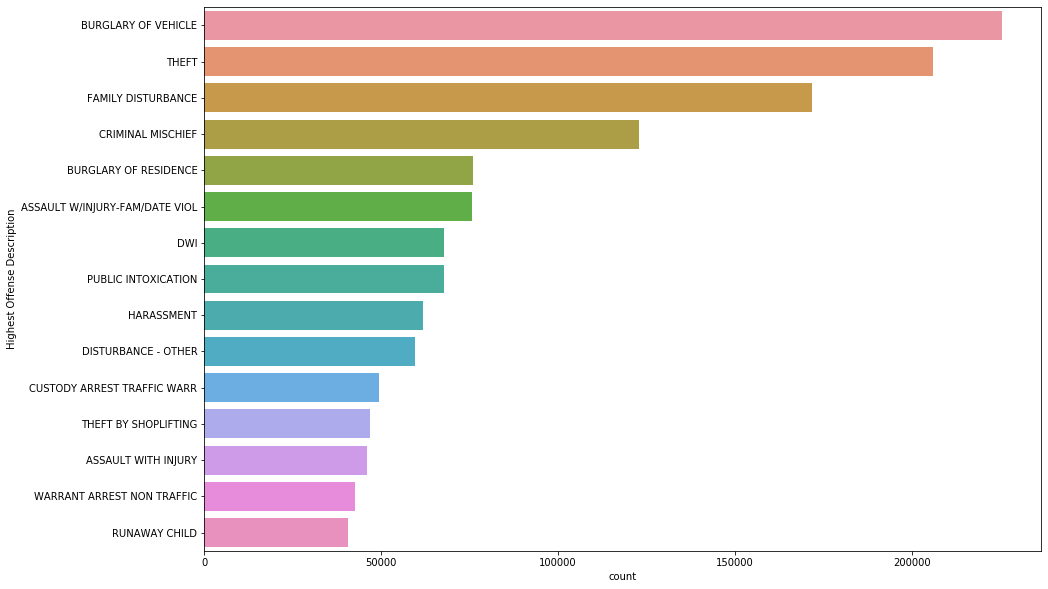

In [24]:
top15Crimes = austinCrime['Highest Offense Description'].value_counts().iloc[:15].index
plt.figure(figsize=(15,10))
sns.countplot(y='Highest Offense Description', data=austinCrime, order= top15Crimes)

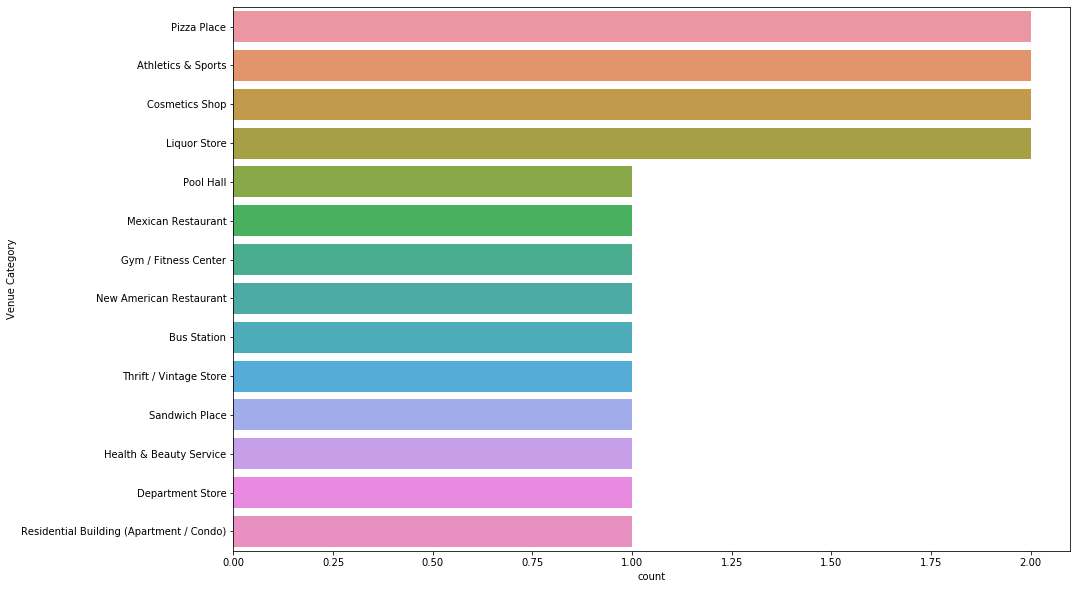

In [25]:
exploreVenues = austin_venues[austin_venues.Zipcode == 78741]
topVenueTypes = exploreVenues['Venue Category'].value_counts().index
plt.figure(figsize=(15,10))
sns.countplot(y='Venue Category', data=exploreVenues, order= topVenueTypes)

Text(0, 0.5, 'Numer of Crimes')

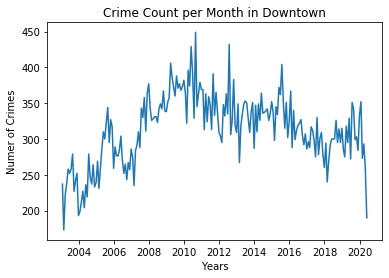

In [26]:
timeSeriesPlot = regionCrime.resample('M').size()
plt.plot(timeSeriesPlot)
plt.title('Crime Count per Month in Downtown')
plt.xlabel('Years')
plt.ylabel('Numer of Crimes')

In [27]:
timeSeries.columns = ['Date', 'Crime Count']
timeSeries

,Date,Crime Count
0,2003-01-31,237
1,2003-02-28,173
2,2003-03-31,222
3,2003-04-30,238
4,2003-05-31,258
...,...,...
204,2020-01-31,352
205,2020-02-29,273
206,2020-03-31,293
207,2020-04-30,260


In [28]:
austinProphet = timeSeries.rename(columns = {'Date': 'ds', 'Crime Count':'y'})

In [29]:
austinProphet['y_orig'] = austinProphet['y']
austinProphet['y'] = np.log(austinProphet['y'])
austinProphet

,ds,y,y_orig
0,2003-01-31,5.468060,237
1,2003-02-28,5.153292,173
2,2003-03-31,5.402677,222
3,2003-04-30,5.472271,238
4,2003-05-31,5.552960,258
...,...,...,...
204,2020-01-31,5.863631,352
205,2020-02-29,5.609472,273
206,2020-03-31,5.680173,293
207,2020-04-30,5.560682,260


In [67]:
austinProphetTrain = austinProphet[austinProphet.ds < '2019-01-31']
austinProphetTest = austinProphet[austinProphet.ds >= '2019-01-31']
austinProphetTrain

,ds,y,y_orig
0,2003-01-31,5.468060,237
1,2003-02-28,5.153292,173
2,2003-03-31,5.402677,222
3,2003-04-30,5.472271,238
4,2003-05-31,5.552960,258
...,...,...,...
187,2018-08-31,5.786897,326
188,2018-09-30,5.686975,295
189,2018-10-31,5.749393,314
190,2018-11-30,5.686975,295


In [31]:
m = Prophet()
m.fit(austinProphetTrain)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
# Since the training data stops at 2019, and we want to predict to 2021, 
#Prophet will make predictions for 36 periods or 36 months.
future = m.make_future_dataframe(periods=36, freq='M')
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-01-31,5.409094,5.301750,5.501435,5.409094,5.409094,-0.009671,-0.009671,-0.009671,-0.009671,-0.009671,-0.009671,0.0,0.0,0.0,5.399423
1,2003-02-28,5.414401,5.165478,5.349258,5.414401,5.414401,-0.158585,-0.158585,-0.158585,-0.158585,-0.158585,-0.158585,0.0,0.0,0.0,5.255816
2,2003-03-31,5.420276,5.331900,5.517157,5.420276,5.420276,-0.001594,-0.001594,-0.001594,-0.001594,-0.001594,-0.001594,0.0,0.0,0.0,5.418682
3,2003-04-30,5.425962,5.319925,5.519210,5.425962,5.425962,-0.005903,-0.005903,-0.005903,-0.005903,-0.005903,-0.005903,0.0,0.0,0.0,5.420059
4,2003-05-31,5.431837,5.408800,5.602295,5.431837,5.431837,0.067325,0.067325,0.067325,0.067325,0.067325,0.067325,0.0,0.0,0.0,5.499163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2021-08-31,5.551657,5.487034,5.683382,5.517003,5.586254,0.031146,0.031146,0.031146,0.031146,0.031146,0.031146,0.0,0.0,0.0,5.582803
224,2021-09-30,5.548355,5.428060,5.631095,5.512320,5.585579,-0.018751,-0.018751,-0.018751,-0.018751,-0.018751,-0.018751,0.0,0.0,0.0,5.529604
225,2021-10-31,5.544943,5.468672,5.683267,5.506950,5.584069,0.032710,0.032710,0.032710,0.032710,0.032710,0.032710,0.0,0.0,0.0,5.577654
226,2021-11-30,5.541642,5.418411,5.632032,5.501870,5.582537,-0.013436,-0.013436,-0.013436,-0.013436,-0.013436,-0.013436,0.0,0.0,0.0,5.528206


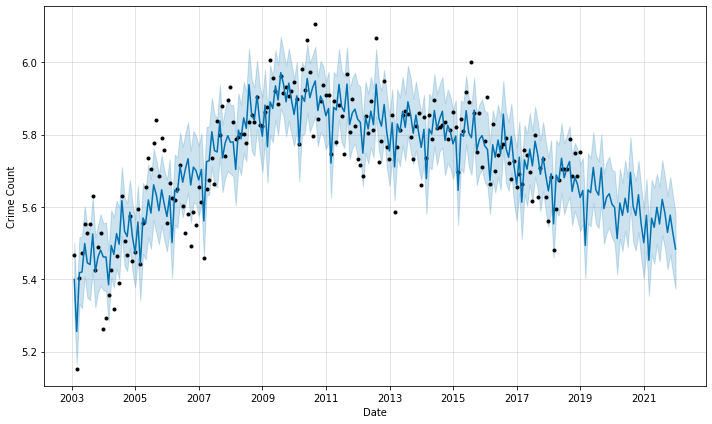

In [68]:
figure = m.plot(forecast, xlabel = 'Date', ylabel = 'Crime Count')

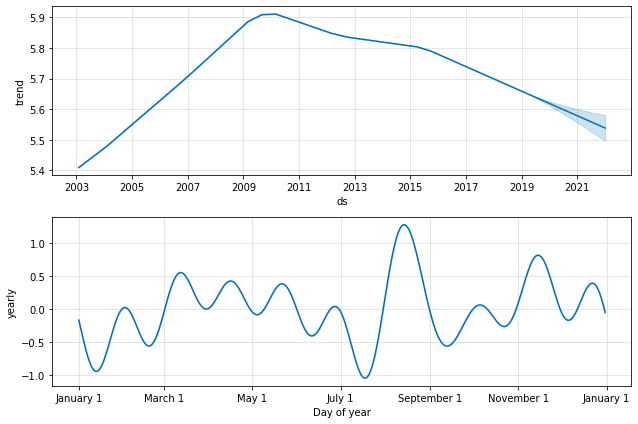

In [34]:
figure = m.plot_components(forecast)

In [35]:
yhat = forecast[forecast.ds >= '2019-01-31']
yhat = yhat[yhat.ds <= '2020-05-31']
yhat

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
192,2019-01-31,5.655443,5.552359,5.735524,5.655443,5.655443,-0.009671,-0.009671,-0.009671,-0.009671,-0.009671,-0.009671,0.0,0.0,0.0,5.645772
193,2019-02-28,5.652361,5.402332,5.593817,5.652361,5.652408,-0.158585,-0.158585,-0.158585,-0.158585,-0.158585,-0.158585,0.0,0.0,0.0,5.493777
194,2019-03-31,5.648950,5.554941,5.748553,5.648770,5.649247,-0.001594,-0.001594,-0.001594,-0.001594,-0.001594,-0.001594,0.0,0.0,0.0,5.647355
195,2019-04-30,5.645648,5.546055,5.734769,5.645036,5.646322,-0.005903,-0.005903,-0.005903,-0.005903,-0.005903,-0.005903,0.0,0.0,0.0,5.639745
196,2019-05-31,5.642236,5.611939,5.806629,5.641008,5.643587,0.067325,0.067325,0.067325,0.067325,0.067325,0.067325,0.0,0.0,0.0,5.709561
197,2019-06-30,5.638934,5.553989,5.744318,5.637081,5.640902,0.008279,0.008279,0.008279,0.008279,0.008279,0.008279,0.0,0.0,0.0,5.647213
198,2019-07-31,5.635522,5.541927,5.726080,5.632894,5.638080,-0.002666,-0.002666,-0.002666,-0.002666,-0.002666,-0.002666,0.0,0.0,0.0,5.632857
199,2019-08-31,5.632110,5.608057,5.802197,5.628550,5.635515,0.076051,0.076051,0.076051,0.076051,0.076051,0.076051,0.0,0.0,0.0,5.708161
200,2019-09-30,5.628809,5.498186,5.692057,5.624385,5.633064,-0.033250,-0.033250,-0.033250,-0.033250,-0.033250,-0.033250,0.0,0.0,0.0,5.595559
201,2019-10-31,5.625397,5.528325,5.724740,5.620142,5.630527,0.001349,0.001349,0.001349,0.001349,0.001349,0.001349,0.0,0.0,0.0,5.626745


# Scoreing the Model

In [36]:
mse = mean_squared_error(austinProphetTest['y'], yhat['yhat'])
print('MSE:', mse)

MSE: 0.023142789361884304


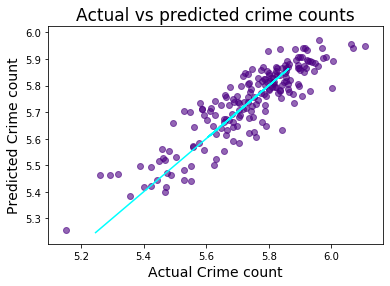

In [46]:
#Graph of actual values vs fitted values
fore = forecast[forecast.ds < '2019-01-31']
plt.scatter(x=austinProphetTrain['y'], y=fore['yhat'], c='indigo', alpha=0.6)
plt.plot(austinProphetTest['y'], austinProphetTest['y'], color='cyan')
plt.xlabel('Actual Crime count', fontsize=14)
plt.ylabel('Predicted Crime count', fontsize=14)
plt.title('Actual vs predicted crime counts', fontsize=17)
plt.show() 

Getting all of the ranges for the diffrent areas

In [47]:
def zipcodeProphet(zipcodes, crimeData):
    
    crimeRates = pd.DataFrame(columns = ['Zipcode', 'CrimeRate_upperBound', 'CrimeRate',
                                        'CrimeRate_lowerBound'])
    
    for zipcode in zipcodes:
        #print(zipcode)
        region = crimeData[crimeData['Zipcode'] == zipcode]
        #print(region)
        timeSeries = region.resample('M').size().reset_index()
        timeSeries.columns = ['Date', 'CrimeCount']
        p = timeSeries.rename(columns = {'Date': 'ds', 'CrimeCount':'y'})
        
        p['y'] = np.log(p['y'])
        p['y'] = p['y'].replace([np.inf, -np.inf, np.nan], 0)
        model = Prophet()
        if len(p) > 2:
            model.fit(p)
            future = model.make_future_dataframe(periods=12, freq='M')
            forecast = model.predict(future)

            row = forecast.loc[forecast['ds'] == '2021-03-31']
            if len(row['yhat'].values) != 0:
                yhat = np.exp(row['yhat'].values[0])
                yhat_up = np.exp(row['yhat_upper'].values[0])
                yhat_down = np.exp(row['yhat_lower'].values[0])
            else:
                yhat = None
                yhat_up = None
                yhat_down = None
        else:
                yhat = None
                yhat_up = None
                yhat_down = None
        
        newEntry = {'Zipcode': zipcode, 'CrimeRate_upperBound': yhat_up, 
                    'CrimeRate': yhat, 'CrimeRate_lowerBound': yhat_down}
        crimeRates = crimeRates.append(newEntry, ignore_index="True")
        
    return crimeRates

In [48]:
crimeRates = zipcodeProphet(venue_zipcodes, austinCrime)
crimeRates

C:\Users\Damian\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
IN

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,Zipcode,CrimeRate_upperBound,CrimeRate,CrimeRate_lowerBound
0,78712.0,2.957771,1.551130,0.803642
1,78756.0,77.636291,64.607705,54.575322
2,78705.0,205.949649,180.440750,156.943562
3,78701.0,715.524743,612.285398,513.332037
4,78702.0,388.853851,351.335317,314.991926
5,78634.0,NaN,NaN,NaN
6,78664.0,NaN,NaN,NaN
7,78704.0,560.574169,511.504529,465.011527
8,78748.0,312.197334,282.558109,252.204366
9,78757.0,223.347512,201.335454,182.210471


In [57]:
#crimeRates.Zipcode = crimeRates.Zipcode.astype(int)
crimeRates = pd.read_csv('CrimeRates.csv')
crimeRates

,Zipcode,CrimeRate_upperBound,CrimeRate,CrimeRate_lowerBound
0,78705,206.578725,180.440750,156.755791
1,78701,721.386492,612.285398,519.280351
2,78712,2.968375,1.551130,0.818266
3,78756,76.955282,64.607705,53.650061
4,78702,388.035248,351.335317,315.668133
5,78704,561.352634,511.504529,466.263476
6,78748,315.974861,282.558109,254.609598
7,78757,225.310930,201.335454,182.350548
8,78722,63.851515,53.484633,43.512841
9,78753,695.457331,642.080472,595.902294


In [58]:
totalUp = crimeRates['CrimeRate_upperBound'].sum()
totalAvg = crimeRates['CrimeRate'].sum()
totalDown = crimeRates['CrimeRate_lowerBound'].sum()
print('Max predicted total:', totalUp)
print('Mean predicted total:', totalAvg)
print('Min predicted total:', totalDown)

Max predicted total: 8816.168615861878
Mean predicted total: 7827.846749329853
Min predicted total: 6969.927631256593


In [59]:
copyFrame = crimeRates
copyFrame['CrimeRate_upperBound'] = copyFrame['CrimeRate_upperBound'] / totalUp
copyFrame['CrimeRate'] = copyFrame['CrimeRate'] / totalAvg
copyFrame['CrimeRate_lowerBound'] = copyFrame['CrimeRate_lowerBound'] / totalDown
copyFrame

,Zipcode,CrimeRate_upperBound,CrimeRate,CrimeRate_lowerBound
0,78705,0.023432,0.023051,0.022490
1,78701,0.081825,0.078219,0.074503
2,78712,0.000337,0.000198,0.000117
3,78756,0.008729,0.008254,0.007697
4,78702,0.044014,0.044883,0.045290
5,78704,0.063673,0.065344,0.066896
6,78748,0.035840,0.036097,0.036530
7,78757,0.025557,0.025720,0.026162
8,78722,0.007243,0.006833,0.006243
9,78753,0.078884,0.082025,0.085496


In [60]:
copyFrame['CrimeRate_upperBound'] = copyFrame['CrimeRate_upperBound'] * 100
copyFrame['CrimeRate'] = copyFrame['CrimeRate'] * 100
copyFrame['CrimeRate_lowerBound'] = copyFrame['CrimeRate_lowerBound'] * 100
copyFrame

,Zipcode,CrimeRate_upperBound,CrimeRate,CrimeRate_lowerBound
0,78705,2.343180,2.305113,2.249030
1,78701,8.182540,7.821888,7.450298
2,78712,0.033670,0.019816,0.011740
3,78756,0.872888,0.825357,0.769736
4,78702,4.401405,4.488275,4.529002
5,78704,6.367308,6.534422,6.689646
6,78748,3.584038,3.609653,3.652973
7,78757,2.555656,2.572041,2.616247
8,78722,0.724255,0.683261,0.624294
9,78753,7.888430,8.202517,8.549620


## 2.4 Connecting the Data together

Now with all of the crime rates calculated it's time to create a folium map and display the top venues with their Crime Rates. In order to show how the crime near their venue is mesured it will use a color system. 

Red- an area that has a predicted crime rate above the 90 percentile

Yellow- an area that is above the 40 percentile and below 90

Green- an area below the 40 percentile

White- Not enough data avalible.

In [65]:
austin_map = folium.Map(location=[AUSTIN_LAT, AUSTIN_LONG], zoom_start=12, tiles='Stamen Terrain')

In [66]:
top80 = copyFrame['CrimeRate'].quantile(.9)
top40 = copyFrame['CrimeRate'].quantile(.4)

for lat, long, venue, rating, code in zip(topTenVenues['Venue Latitude'], topTenVenues['Venue Longitude'], topTenVenues['Venue'], topTenVenues['Venue Rating'], topTenVenues['Zipcode']):
    row = copyFrame.loc[copyFrame['Zipcode'] == code]
    if row['CrimeRate'].values[0] != np.nan:
        if row['CrimeRate'].values[0] >= top80:
            color = 'red'
            colorHex = '#ab1916'
            rate = 'High'
        elif row['CrimeRate'].values[0] >= top40:
            color = 'yellow'
            colorHex = '#e3d134'
            rate = 'moderate'
        else:
            color = 'green'
            colorHex = '#4ab82c'
            rate = 'low'
    else:
        color = 'white'
        colorHex = '#e9eef2'
        rate = 'Unknown'
    
    label = folium.Popup(str(venue) +'  Crime Rate: ' + str(rate), parse_html=True)
    
    folium.CircleMarker([lat, long], radius = 5, popup = label, color = color, fill = True,
                       fill_color=colorHex, fill_opacity=0.7).add_to(austin_map)
austin_map    